# Player Rating Algorithm Development

#### Initial Creation Date: 2021/12/01
#### Author: Ben Farrell
#### Last Modified: 2022/01/13


## Contents

* [1] - [Imports](#imports)
* [2] - [Understanding ELO](#understanding_elo)
* [3] - [Pros & Cons of ELO](#pro_con_elo)
* [4] - [Extending Basic ELO](#extending_elo)
* [4.1] - [Margin of Victory](#mov)
* [4.2] - [Doubles Matches](#doubles)
* [5] - [Evaluating the algorithm](#evaluation)
* [6] - [Parameter Optimization](#optimiztion)
* [7] - [Overview of multi-dimensional feature space](#feature_space)
* [8] - [Cold Start Problem](#cold_start)

<a id='imports'></a>
## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from pathlib import Path
# from mpl_toolkits import mplot3d
from ast import literal_eval
from elopackage.player import Player
from elopackage.elo import Elo
from elopackage.results import ResultsTable
from elopackage.preprocess import preprocess_tour_data
import os
# from tqdm.notebook import tqdm
import time

In [3]:
df = preprocess_tour_data('player_tournament_results_2019_downsampled_15_prc.csv')
results = ResultsTable(df)
results.check_prediction(kfactor=125,sd=545,acf=530)

0.1985334730164738

<a id='understanding_elo'></a>
## Understanding ELO

The fundamentals of ELO predictions assume that each players skill can be represented as continuous probability distribution, commonly known as normal or [Gaussian distritbution](https://en.wikipedia.org/wiki/Normal_distribution).
Each player will then have a mean "skill' and 'variance' - squared deviation from the mean.

##### Probability Density Function (PDF) and Cumulative Distribution Function (CDF)
Original implementations of ELO assumed that each player's skill was a normally distributed real-valued random variable. To determine the probability that one player would beat another, you had to evalute the probability that $X_1$ ~ $N(\mu_1,\sigma_1^2)$ would return a higher skill than $X_2$ ~ $N(\mu_2,\sigma_2^2)$


In [4]:
sorted_player_rank = sorted([v for v in results.player_dict.values()], key=lambda x: x.rating)

In [5]:
sorted_player_rank[-2].name

'Sheunesu Kimbugwe'

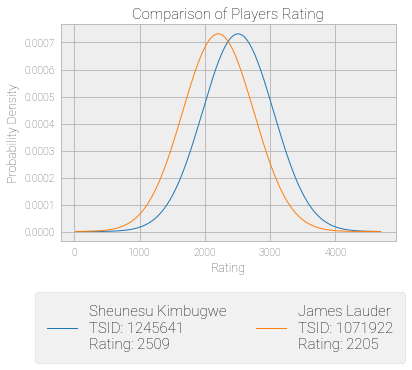

In [6]:
sorted_player_rank[-2].visualize_competitor(sorted_player_rank[-50])

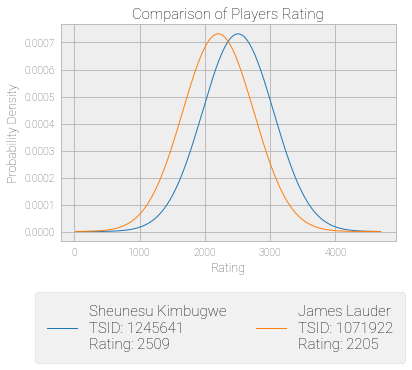

In [17]:
fig1 = sorted_player_rank[-2].visualize_competitor(sorted_player_rank[-50])

#### So how do we determine likelihood of Player A beating Player B?
All randomly distributed variables can be represented as a linear combination of other randomly distributed variables. Therefore, the problem outlined above can be summarised as follows:

\begin{equation}
P(X_1 > X_2) = P(X_1 - X_2 > 0) = 1 - P(X_1 - X_2 < 0)
\end{equation}

Linear Combination of means:
\begin{equation}
\mu = E(X_1 - X_2) = \mu_1 - \mu_2
\end{equation}

Standard Deviation
\begin{equation}
\sigma = Var(X_1 - X_2) = \sqrt{\sigma_1^2 + \sigma_2^2}
\end{equation}

Determining the probability that this new linear combination is greater than zero can be achieved by comparing this distribution to the Standard Normal Distribution $Z$ ~ $N(0,1)$:

\begin{equation}
X = Z\sigma + \mu
\end{equation}

Therefore:
\begin{equation}
P(X_1 - X_2 > 0) = P(X > 0) = P(Z\sigma + \mu > 0) = P(Z > \frac{-\mu}{\sigma}) = \phi{(\frac{-\mu}{\sigma})}
\end{equation}

This problem has been reduced to calculating whether the cumulative distribution function (CDF) $\phi$ is greater than some mean divided by some standard deviation.

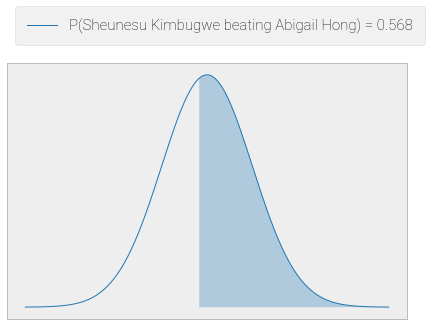

In [6]:
sorted_player_rank[-2].visualize_prob_winning(sorted_player_rank[-10])

#### Logistic Function
New versions of ELO use the logistic function instead of the CDF:
\begin{equation}
f(x) = \frac{L}{1-e^{-k(x-x_0)}}
\end{equation}

- $L$ maximum value of function $\lim_{x \to +\infty}$
- $k$ steepness factor of logistic function
- $x_o$ - Value of $x$ at mid point


The normal logistic function can be transformed to provide the probability that one player will beat another as show below:

$$p_A=\frac{1}{1 + b^-\frac{d}{s}}$$


- $p_A$ : probability of player A winning
- $b$ : base (this can be 10, $e$ etc)
- $d$ : difference between player mean skill
- $s$ : scale factor (Constant Standard Deviation of player rating $\sigma$=200)


If we use base 10, instead of natural logarithm used in original logistic function we get the below formula:

$$E_A=\frac{1}{1+10^\frac{R_B-R_A}{s}}$$

- $E_A$ - Expected probability of Player $A$ winning.
- $R_B$ - Player $R_B$ mean rating*
- $R_A$ - Player $R_A$ mean rating*
- $s$ : scale factor (Constant Standard Deviation of player rating $\sigma$=200)

*Mean rating of a player assumed normally (Gaussian) distributed skill.


In [21]:
x = np.arange(-1000,1001,1)
expected_prob = 1 / (1 + 10 ** ((x) / 400))
expected_prob_lr = stats.norm(loc=x, scale=400).cdf(0)

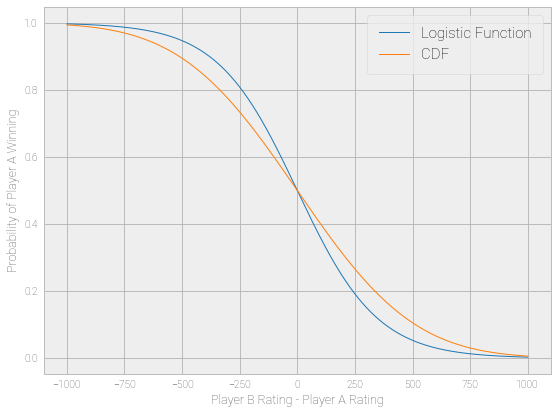

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, expected_prob, label='Logistic Function')
ax.plot(x, expected_prob_lr, label = 'CDF')
ax.set_xlabel('Player B Rating - Player A Rating')
ax.set_ylabel('Probability of Player A Winning')
ax.legend()
plt.tight_layout()

In [24]:
fig.savefig('../logistic_vs_cdf.png')

#### Then how does a Players Rating Change after a match?

With basic ELO we ues the following equation:

\begin{equation}
\delta = (actual - expected) * K_{factor} \\ \\
score_{new} = score_{prior} + \delta
\end{equation}

This takes the predicted outcome of match. i.e Probabiliy of player A beating player B and compares it to the actual outcome. 

- When the outcome is close to the expected, the result of this expression tends to 0
- However when the prediction is very different from the outcome this value can tend to either -1 or 1.

The above value is multiplied by some factor to determine the change to a player rating. So when the prediction is **very** right, then player rating change is small. However, when the prediction is **very** wrong, the player rating change is large.

This k-factor is basically the speed at which the algorithm converages on the true rating of a player.

In [18]:
def get_stats_on_player(rank_player):
    p = sorted_player_rank[rank_player]
    wins = (df.winning_team_p1 == p.name).sum() + (df.winning_team_p2 == p.name).sum()
    losses = (df.losing_team_p1 == p.name).sum() + (df.losing_team_p2 == p.name).sum()
    
    print(f'Player: {p.name}\nWins: {wins}\nLosses: {losses}')

In [19]:
get_stats_on_player(-15)

Player: Blake Hoang
Wins: 41
Losses: 14


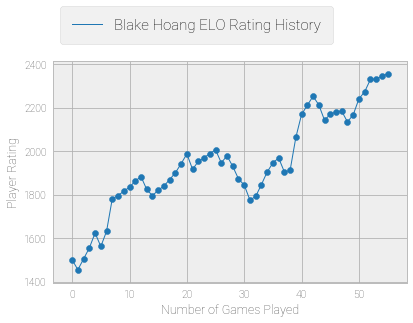

In [20]:
sorted_player_rank[-15].visualize_rating_hist()

In [42]:
get_stats_on_player(22)

Player: Henry Wright
Wins: 10
Losses: 50


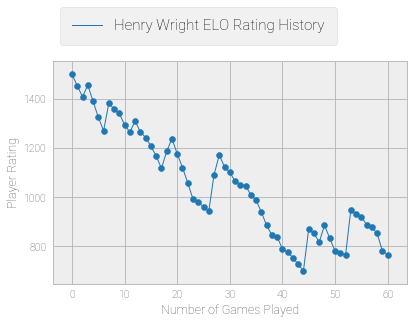

In [39]:
sorted_player_rank[22].visualize_rating_hist()

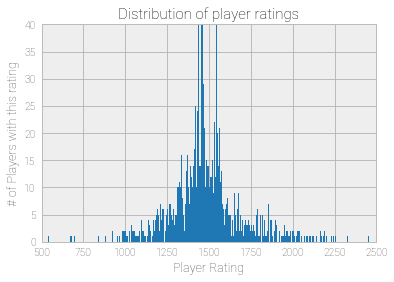

In [44]:
fig, ax = plt.subplots()
ax.hist([p.rating for p in sorted_player_rank], bins=2000)
ax.set_xlim(500, 2500)
ax.set_ylim(0,40)
ax.set_title('Distribution of player ratings')
ax.set_xlabel('Player Rating')
ax.set_ylabel('# of Players with this rating');

<a id='pro_con_elo'></a>
## Pros & Cons of ELO

The basic ELO methodology doesn't account for the following:

- Multi-player settings
- Agnostic to significance of actual match - Basic club match vs national champs final
- Home Advantage
- Margin of Victory
- No consideration to degregation of player ratings over time if not playing.
 - This can discourage top ranked players from playing.
- Players skill distribution remains fixed. Potentially unrealistic for experienced players who could be said to have a narrower range of typical performance.


#### Benefits of remaining with a Basic ELO System

- Simple ELO systems have been proven to be effective in many sports.
- Trying to account for the above additional factors will always incur some subjectivity when selecting parameters.
- The impact on ratings becomes less clearly defined and can result in lower player satisfication if they can't easily see the link between performance and overall rating.
- The more complex approach are also prone to cheating, if players are able to identify scenarios in which to boost their scores unfairly due to some limitations/edge cases in the logic.


<a id='extending_elo'></a>
## Extending Basic ELO

### Assumptions

- Matches where points aren't recorded are dorpped/not counted.
- All unrated players begin with a skill of 1500
- If a player doesn't have a tsid, then they are assumed to be a new player and given a generated tsid begining with 2,000,0001
    - This will repeatedly be the case if they appear in a tournament more than once because with name alone it is impossible to distinguish between players.

<a id='mov'></a>
### Margin of Victory

Methodology:

* 1 - Dropped matches where score wasn't present - e.g n/a
* 2 - Converted scores saved as list to strings
* 3 - Found overall pts difference to winner over match
* 4 - Found pts difference for individual games within a match


Summary of Points Difference Analysis
- **The mean pts_diff observed was 11.7 points**
- The max pts_diff observed is unsurprisingly 42, which accounts for 21-0 each game.
- We do also see a small number of occassions where the pts_diff was actually negative for the winner, indicating that there were some games which they lost by a significant margin despite winning overall.

,pts_diff
count,35533.000000
mean,11.709453
std,7.016293
min,-13.000000
25%,7.000000
50%,11.000000
75%,16.000000
max,42.000000


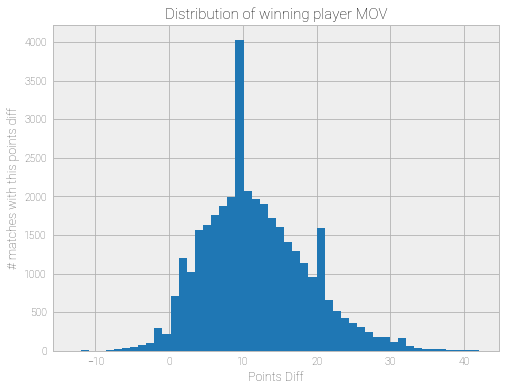

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
results.df['pts_diff'].plot(kind='hist',bins=50, ax=ax)
ax.set_title('Distribution of winning player MOV')
ax.set_xlabel('Points Diff')
ax.set_ylabel('# matches with this points diff');

results.df[['pts_diff']].describe()

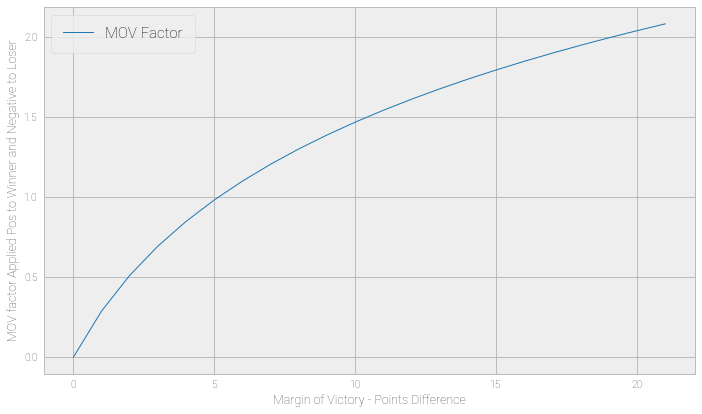

In [46]:
x = np.arange(0,22,1)
y = np.log(1+x/3)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y, label='MOV Factor')
ax.set_xlabel('Margin of Victory - Points Difference')
ax.set_ylabel('MOV factor Applied Pos to Winner and Negative to Loser')
ax.legend()
plt.tight_layout()

fig.savefig('../MOV_factor.png')

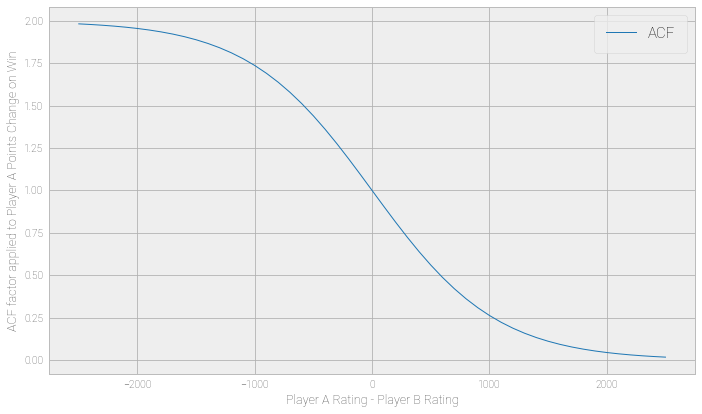

In [47]:
x = np.arange(-2500,2600,100)
auto_corr = 2 / (1 + np.exp((x) / 530))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, auto_corr, label='ACF')
ax.set_xlabel('Player A Rating - Player B Rating')
ax.set_ylabel('ACF factor applied to Player A Points Change on Win')
ax.legend()
plt.tight_layout()
fig.savefig("../ACF.png")

<a id='doubles'></a>
### Extending to Doubles Matches

The idea behind extending ELO to doubles matches centers on the principle that all random normal distributions can be formed from a linear combination of other normal random distributions.

Therefore if we consider two individual players each with mean skill and variance $\mu_1$ and $\mu_2$ $\sigma_{1}^2$ and $\sigma_{2}^2$ respectively, we can in theory take the combination of the two as new player.

This then allows us to estimate the likelihood of one pair of players beating another pair of players.

When it comes to re-rating the players after the result, some consideration should be given to ensure this is correctly attributed. This is a subjective matter but I offer the following approach.

- Two equally skilled players (P1 == P2) should half the distribution of the points.
- When skill of P1 > P2, then P1 should recieve less of the points change.
- When skill of P1 < P2, then P1 should recieve more of the points change.

Subjective justification for this argument:

- Stronger player on team can only control play when they serve or receive serve which is at most 50% of points. However, the opposition will, where possible, play shots to the weakest member of the oppoosition. Thereby likely reducing the percentage of occassions that the stronger player can control the match. This percentage skew will increase more when the difference in skill between doubles parterns is higher and opposition can easily identify weaker player.

A reasonable points split can then be achieved with an application of the logistic function, comparing the difference in doubles players mean skill, to the constant standard deviation applied to all players.

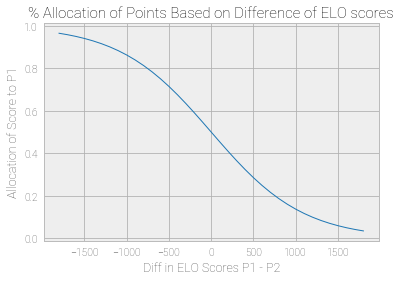

In [59]:
def points_share(p1,p2):
    
    return 1 / (1 + math.exp((p1-p2)/545))

p1_scores = np.arange(200,3900,100)

p2_scores = np.array([2000] * len(p1_scores))

p1_allocation = [points_share(p1,p2) for p1, p2 in zip(p1_scores, p2_scores)]

p_diff = p1_scores - p2_scores

fig, ax = plt.subplots()
ax.plot(p_diff, p1_allocation)
ax.set_title('% Allocation of Points Based on Difference of ELO scores')
ax.set_xlabel('Diff in ELO Scores P1 - P2')
ax.set_ylabel('Allocation of Score to P1');

#### Is a linear combination of players skill the best approach?

Here we have the option to represent a doubles team as the summation of individual player skills, or the mean of the players skills. Considering sporting logic, I think it makes more sense to average the players rating. This will be more representative of the average rating per play/shot within match.

This can be shown by running a simulation which selects a potential skill from the rating distribution for each player 10,000 times. The mean rating can then calculated.I'll run a test to see what the mean is when taking 30 samples from each players distribution, to see what the new distribution will be.


565.685424949238

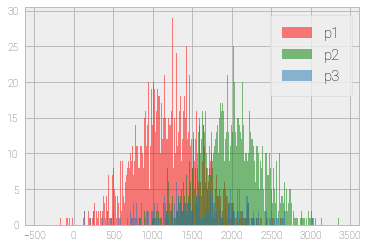

In [61]:
p1 = np.random.normal(1200,400,10000)
p2 = np.random.normal(2000,400,10000)
p3 = np.array(list(np.random.choice(p1,1000)) + list(np.random.choice(p2,1000)))

fig, ax = plt.subplots()
ax.hist(p1,bins=2000, color='r', alpha=0.5, label='p1')
ax.hist(p2,bins=2000, color='g', alpha=0.5, label='p2')
ax.hist(p3,bins=2000, alpha=0.5, label='p3')
ax.legend();


np.mean(p3)

np.std(p3)

#This is the same as 
math.sqrt(400**2 + 400**2)

The the empirically calculated mean is approx:

\begin{equation}
\mu = \frac{\mu_1 + \mu_2}{2}
\end{equation}

The empirically calculated standard deviation is approximately the linear combination of standard deviation:

\begin{equation}
\sigma = \sqrt{\sigma_1^2 + \sigma_2^2}
\end{equation}

<a id='evaluation'></a>
## Evaluating the Algorithm

#### Basic Accuracy
Count on how many occassions the prediction made by model was correct.

#### Brier Score
This will compare the prediction compared to the reality. Large expected results which are correct are rewarded highly, but incorrect ones are greatly punished also because it is comparing a square of the distance.

Wiki Reference [Brier Score](https://en.wikipedia.org/wiki/Brier_score) 

\begin{equation}
BS = \frac{1}{N}\sum_{t=1}^{N}(f_t - o_t)^2
\end{equation}

$BS$ - Brier Score

$N$ - Number of forecasting instances

$f_t$ - Forecast probability for particular observation

$o_t$ - Actual outcome of the event

<a id='optimiztion'></a>
## Parameter Optimization

The below section will show the four rounds of optimization conducted to improve the briers score (accuracy of the rating algorithm)

The feature space consists of three key parameters:

* SD ($\sigma$) - Standard deviation of player skill
* k-factor - This impact the speed at which the algoritm converages. The higher the value, the higher the importance given to most recent match. Lower values will take longer to converage on "True" rating, but will be more stable.
* ACF - Regularization term to reduce prevent perpetual growth of top rated player. Discounts points distribution of winners and increases that of underdogs who win unexpectedly.

#### Defintion:
**Basic ELO** - This treats all matches as a binary outcome. Win=1, Loss=0. Points scored during each game/match are not a contributing factor to rating changes.

**Complex ELO** - This approach extends on basic ELO to account for the over points difference in a match. This is the cumulative total over the two or three games played. It also discounts the points transferred to teams which are expected to win and increases the points allocated to 'under-dogs' who win. This prevents highly rated teams from perpetually increasing their score/rating.

In [42]:
sd_range = np.arange(200,510,25)
kfactor_range = np.arange(50,300,25)
acf_range = np.arange(1500,3500,250)

In [43]:
test_results_dict = {'sd':[],
                     'kfactor':[],
                     'acf':[],
                     'briers_score':[],
                     'briers_score_adv':[]}

for s in tqdm(sd_range):
    for k in tqdm(kfactor_range):
        print(f'Working on combination: sd_{s}_kf_{k}')
        for acf in tqdm(acf_range):
            #basic
            rst = ResultsTable(df)
            brier_score = rst.check_prediction(sd=s, kfactor=k)
            #adv - include mov and acf
            rst_adv = ResultsTable(df)
            brier_score_adv = rst_adv.check_prediction(sd=s, kfactor=k, mov=True, acf=acf)
            
            test_results_dict['sd'].append(s)
            test_results_dict['kfactor'].append(k)
            test_results_dict['acf'].append(acf)
            test_results_dict['briers_score'].append(brier_score)
            test_results_dict['briers_score_adv'].append(brier_score_adv)
            
            
df_results = pd.DataFrame.from_dict(test_results_dict)
df_results.to_csv('../optimization_results.csv',index=False)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_200_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_200_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_225_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_225_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_250_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_250_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_275_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_275_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_300_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_300_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_325_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_325_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_350_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_350_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_375_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_375_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_400_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_400_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_425_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_425_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_450_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_450_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_475_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_175


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_475_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working on combination: sd_500_kf_50


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_75


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_100


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_125


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_150


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_200


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_225


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_250


  0%|          | 0/8 [00:00<?, ?it/s]

Working on combination: sd_500_kf_275


  0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
df_results = pd.read_csv('../optimization_results.csv')

In [45]:
df_results.head()

,sd,kfactor,acf,briers_score,briers_score_adv
0,200,50,1500,0.201659,0.206102
1,200,50,1750,0.201659,0.206405
2,200,50,2000,0.201659,0.206641
3,200,50,2250,0.201659,0.206830
4,200,50,2500,0.201659,0.206985


In [55]:
df_results.iloc[df_results.idxmin(axis=0)['briers_score']]

sd                   300.000000
kfactor              125.000000
acf                 1500.000000
briers_score           0.195357
briers_score_adv       0.197525
Name: 344, dtype: float64

In [56]:
df_results.iloc[df_results.idxmin(axis=0)['briers_score_adv']]

sd                   500.000000
kfactor              125.000000
acf                 1500.000000
briers_score           0.198022
briers_score_adv       0.190442
Name: 984, dtype: float64

In [97]:
plt.rcParams.update({'font.size': 15})

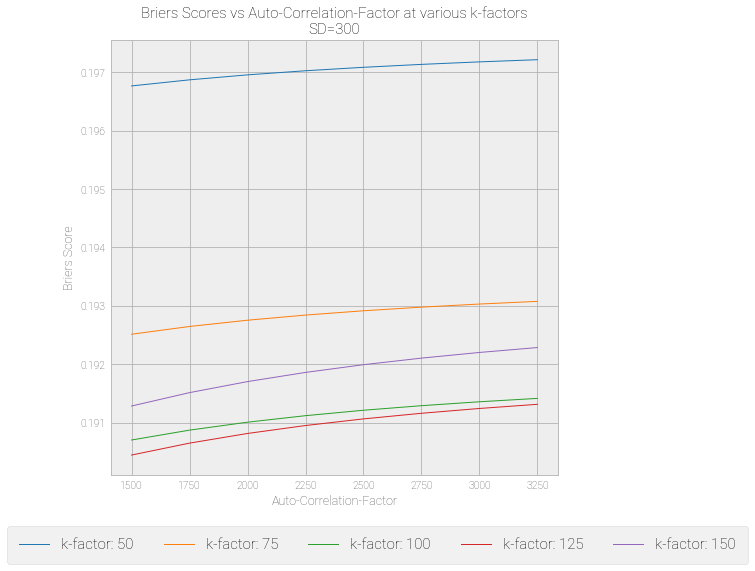

In [106]:
fig, ax = plt.subplots(figsize=(8,8))
for k in kfactor_range[:5]:
    ax.plot(df_results[(df_results['kfactor'] == k) & (df_results['sd'] == 500)]['acf'].values, 
            df_results[(df_results['kfactor'] == k) & (df_results['sd'] == 500)]['briers_score_adv'].values,
            label=f'k-factor: {k}')
ax.legend(bbox_to_anchor=(-0.25,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs Auto-Correlation-Factor at various k-factors\nSD=300')
ax.set_xlabel('Auto-Correlation-Factor')
ax.set_ylabel('Briers Score');

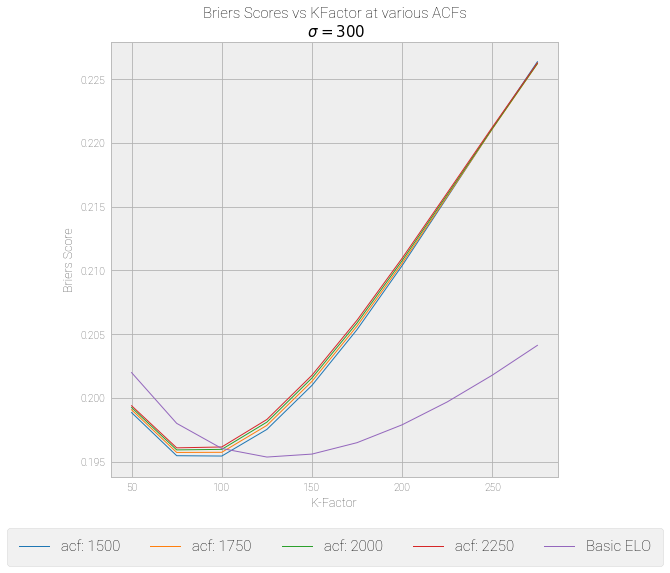

In [109]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[:4]:
    ax.plot(df_results[(df_results['acf'] == a) & (df_results['sd'] == 300)]['kfactor'].values, 
            df_results[(df_results['acf'] == a) & (df_results['sd'] == 300)]['briers_score_adv'].values,
            label=f'acf: {a}')

ax.plot(df_results[(df_results['acf'] == a) & (df_results['sd'] == 300)]['kfactor'].values, 
            df_results[(df_results['acf'] == a) & (df_results['sd'] == 300)]['briers_score'].values,
            label=f'Basic ELO')
ax.legend(bbox_to_anchor=(-0.25,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs KFactor at various ACFs\n $\sigma=300$')
ax.set_xlabel('K-Factor')
ax.set_ylabel('Briers Score');

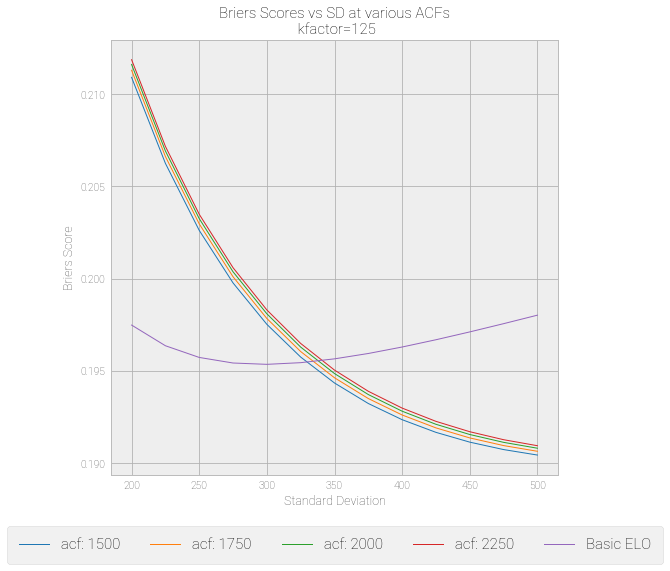

In [111]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[:4]:
    ax.plot(df_results[(df_results['acf'] == a) & (df_results['kfactor'] == 125)]['sd'].values, 
            df_results[(df_results['acf'] == a) & (df_results['kfactor'] == 125)]['briers_score_adv'].values,
            label=f'acf: {a}')
ax.plot(df_results[(df_results['acf'] == a) & (df_results['kfactor'] == 125)]['sd'].values, 
            df_results[(df_results['acf'] == a) & (df_results['kfactor'] == 125)]['briers_score'].values,
            label=f'Basic ELO')
ax.legend(bbox_to_anchor=(-0.25,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs SD at various ACFs\n kfactor=125')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Briers Score');

### Summary of Initial Optimization of Parameters

The feature space to optimize our model consists of three key parameters:

- Standard Deviation for Players. Range(200 -> 510) Step Size = 25
- K-Factor. Range(50 -> 300) Step Size = 25
- Auto-Correlation-Factor. Range(1500 -> 3500) Step Size = 250

**Optimal Parameters for each ELO**

| Type of ELO | SD | K-Factor | Auto-Correlation-Factor | Brier Score |
| --- | --- | --- | --- | --- |
| Basic | 300 | 125 | 1500 | 0.195357 |
| Complex | 500 | 125 | 1500 | 0.190442 |


What is evident from the above results is that over the evaluated feature space, the complex version of ELO results in marginally better Briers Scores and thereby provides the most predictive power when used with the correct combination of features. We see about a 2.5% increase in predictive ability with the complex version of ELO when compared against both with their optimal parameters.

#### Further Optimization
Although with k-factor we were able to demonstrate that the optimal range of parameters had been evaluted, SD and ACF didn't show a clear optimal value and further exploration can be carried out to verify these parameters.


In [125]:
sd_range = np.arange(450,700,50)
kfactor_range = np.arange(100,175,25)
acf_range = np.arange(500,2000,250)

In [158]:
test_results_dict_2 = {'sd':[],
                     'kfactor':[],
                     'acf':[],
                     'briers_score':[],
                     'briers_score_adv':[]}

for s in tqdm(sd_range):
    for k in tqdm(kfactor_range):
        for acf in tqdm(acf_range):
            #basic
            rst = ResultsTable(df)
            brier_score = rst.check_prediction(sd=s, kfactor=k)
            #adv - include mov and acf
            rst_adv = ResultsTable(df)
            brier_score_adv = rst_adv.check_prediction(sd=s, kfactor=k, mov=True, acf=acf)
            
            test_results_dict_2['sd'].append(s)
            test_results_dict_2['kfactor'].append(k)
            test_results_dict_2['acf'].append(acf)
            test_results_dict_2['briers_score'].append(brier_score)
            test_results_dict_2['briers_score_adv'].append(brier_score_adv)
            
            
df_results_2 = pd.DataFrame.from_dict(test_results_dict_2)
df_results_2.to_csv('../optimization_results_2.csv',index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [127]:
df_results_2.iloc[df_results_2.idxmin(axis=0)['briers_score']]

sd                  450.000000
kfactor             150.000000
acf                 500.000000
briers_score          0.196402
briers_score_adv      0.191465
Name: 12, dtype: float64

In [128]:
df_results_2.iloc[df_results_2.idxmin(axis=0)['briers_score_adv']]

sd                  550.000000
kfactor             125.000000
acf                 500.000000
briers_score          0.198966
briers_score_adv      0.189119
Name: 42, dtype: float64

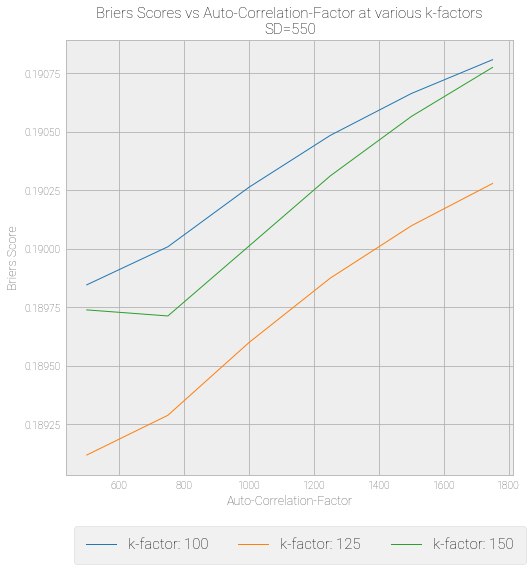

In [135]:
fig, ax = plt.subplots(figsize=(8,8))
for k in kfactor_range[:5]:
    ax.plot(df_results_2[(df_results_2['kfactor'] == k) & (df_results_2['sd'] == 550)]['acf'].values, 
            df_results_2[(df_results_2['kfactor'] == k) & (df_results_2['sd'] == 550)]['briers_score_adv'].values,
            label=f'k-factor: {k}')
ax.legend(bbox_to_anchor=(0,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs Auto-Correlation-Factor at various k-factors\nSD=550')
ax.set_xlabel('Auto-Correlation-Factor')
ax.set_ylabel('Briers Score');

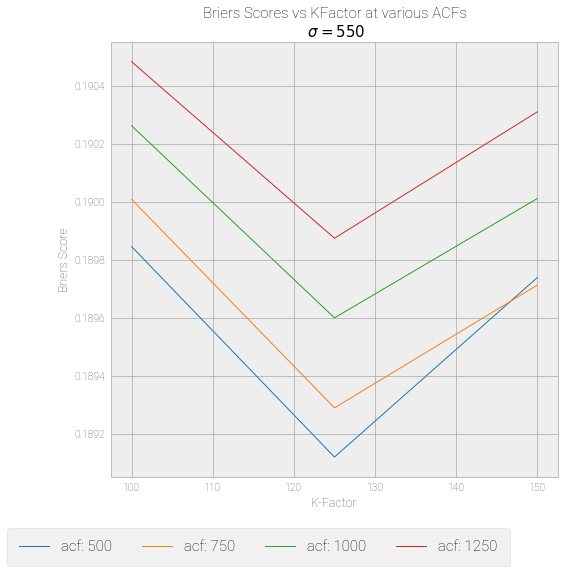

In [140]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[:4]:
    ax.plot(df_results_2[(df_results_2['acf'] == a) & (df_results_2['sd'] == 550)]['kfactor'].values, 
            df_results_2[(df_results_2['acf'] == a) & (df_results_2['sd'] == 550)]['briers_score_adv'].values,
            label=f'acf: {a}')

ax.legend(bbox_to_anchor=(-0.25,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs KFactor at various ACFs\n $\sigma=550$')
ax.set_xlabel('K-Factor')
ax.set_ylabel('Briers Score');

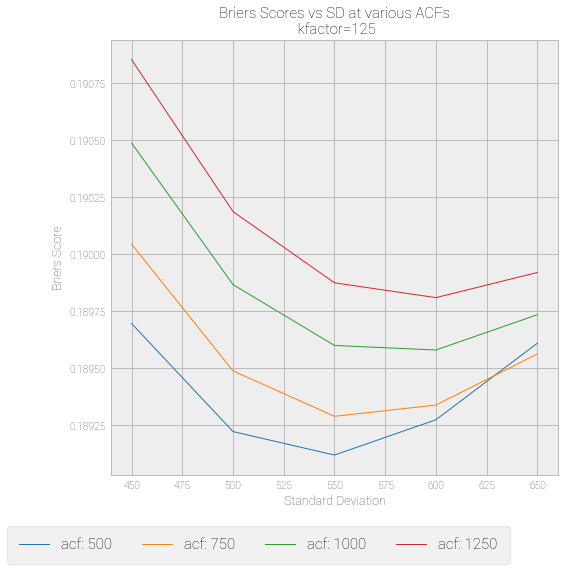

In [139]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[:4]:
    ax.plot(df_results_2[(df_results_2['acf'] == a) & (df_results_2['kfactor'] == 125)]['sd'].values, 
            df_results_2[(df_results_2['acf'] == a) & (df_results_2['kfactor'] == 125)]['briers_score_adv'].values,
            label=f'acf: {a}')
ax.legend(bbox_to_anchor=(-0.25,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs SD at various ACFs\n kfactor=125')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Briers Score');

#### Initial Optimization of Parameters Continued - Round 2

After the inital broad search we were able to refine the search grid.

sd_range = np.arange(450,700,50)
kfactor_range = np.arange(100,175,25)
acf_range = np.arange(500,2000,250)

- Standard Deviation for Players. Range(450 -> 650) Step Size = 50
- K-Factor. Range(100 -> 150) Step Size = 25
- Auto-Correlation-Factor. Range(500 -> 1500) Step Size = 250


#### Optimal Ranges
Parameters from this round of optimization provide a 3.1% improvement over basic ELO.

- k-factor is most likely somewhere between 100 - 150. 
- $\sigma$ is likely between 525 - 575

A fine search can fully optimize both of the above.

Optimal range for ACF is still to be determined.

**Optimal Parameters for each ELO**

| Type of ELO | SD | K-Factor | Auto-Correlation-Factor | Brier Score |
| --- | --- | --- | --- | --- |
| Complex | 550 | 125 | 500 | 0.189119 |


#### Further Optimization
Find optimal values for ACF. This was carried out below: It is now evident that the optimal ACF is within 400-600 range and can be fully optimized in the refined grid search.

In [157]:
sd_range = np.arange(550,600,50)
kfactor_range = np.arange(125,175,50)
acf_range = np.arange(50,1000,50)

test_results_dict_3 = {'sd':[],
                     'kfactor':[],
                     'acf':[],
                     'briers_score':[],
                     'briers_score_adv':[]}

for s in tqdm(sd_range):
    for k in tqdm(kfactor_range):
        for acf in tqdm(acf_range):
            #basic
            rst = ResultsTable(df)
            brier_score = rst.check_prediction(sd=s, kfactor=k)
            #adv - include mov and acf
            rst_adv = ResultsTable(df)
            brier_score_adv = rst_adv.check_prediction(sd=s, kfactor=k, mov=True, acf=acf)
            
            test_results_dict_3['sd'].append(s)
            test_results_dict_3['kfactor'].append(k)
            test_results_dict_3['acf'].append(acf)
            test_results_dict_3['briers_score'].append(brier_score)
            test_results_dict_3['briers_score_adv'].append(brier_score_adv)
            
            
df_results_3 = pd.DataFrame.from_dict(test_results_dict_3)
df_results_3.to_csv('../optimization_results_3.csv',index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [155]:
df_results_3.iloc[df_results_3.idxmin(axis=0)['briers_score_adv']]

sd                  550.000000
kfactor             125.000000
acf                 550.000000
briers_score          0.198966
briers_score_adv      0.189116
Name: 10, dtype: float64

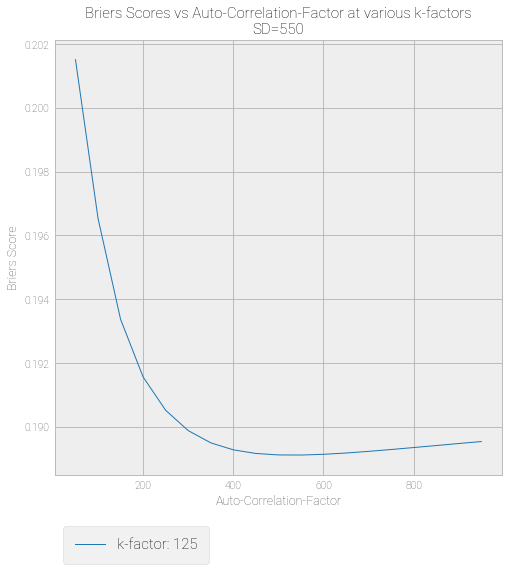

In [156]:
fig, ax = plt.subplots(figsize=(8,8))
for k in kfactor_range[:5]:
    ax.plot(df_results_3[(df_results_3['kfactor'] == k) & (df_results_3['sd'] == 550)]['acf'].values, 
            df_results_3[(df_results_3['kfactor'] == k) & (df_results_3['sd'] == 550)]['briers_score_adv'].values,
            label=f'k-factor: {k}')
ax.legend(bbox_to_anchor=(0,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs Auto-Correlation-Factor at various k-factors\nSD=550')
ax.set_xlabel('Auto-Correlation-Factor')
ax.set_ylabel('Briers Score');

#### Final Optimization of Parameters - Round 3

After the two broad searches we are now able to do a final ultra-fine search grid for the final parameters. This will complete the optimization of the Brier's Score.

- Standard Deviation for Players. Range(520 -> 580) Step Size = 5
- K-Factor. Range(100 -> 150) Step Size = 5
- Auto-Correlation-Factor. Range(450 -> 600) Step Size = 10


In [160]:
sd_range = np.arange(520,580,5)
kfactor_range = np.arange(100,150,5)
acf_range = np.arange(450,600,10)

In [161]:
test_results_dict_4 = {'sd':[],
                     'kfactor':[],
                     'acf':[],
                     'briers_score_adv':[]}

for s in tqdm(sd_range):
    for k in tqdm(kfactor_range):
        for acf in tqdm(acf_range):
            #adv - include mov and acf
            rst_adv = ResultsTable(df)
            brier_score_adv = rst_adv.check_prediction(sd=s, kfactor=k, mov=True, acf=acf)
            
            test_results_dict_4['sd'].append(s)
            test_results_dict_4['kfactor'].append(k)
            test_results_dict_4['acf'].append(acf)
            test_results_dict_4['briers_score_adv'].append(brier_score_adv)
            
            
df_results_4 = pd.DataFrame.from_dict(test_results_dict_4)
df_results_4.to_csv('../optimization_results_4.csv',index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [169]:
df_results_4.iloc[df_results_4.idxmin(axis=0).briers_score_adv]

sd                  545.000000
kfactor             125.000000
acf                 530.000000
briers_score_adv      0.189112
Name: 833, dtype: float64

In [187]:
df_results_4.describe()

,sd,kfactor,acf,briers_score_adv
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,547.500000,122.500000,520.000000,0.189371
std,17.265059,14.365398,43.216944,0.000233
min,520.000000,100.000000,450.000000,0.189112
25%,533.750000,110.000000,480.000000,0.189177
50%,547.500000,122.500000,520.000000,0.189299
75%,561.250000,135.000000,560.000000,0.189505
max,575.000000,145.000000,590.000000,0.190102


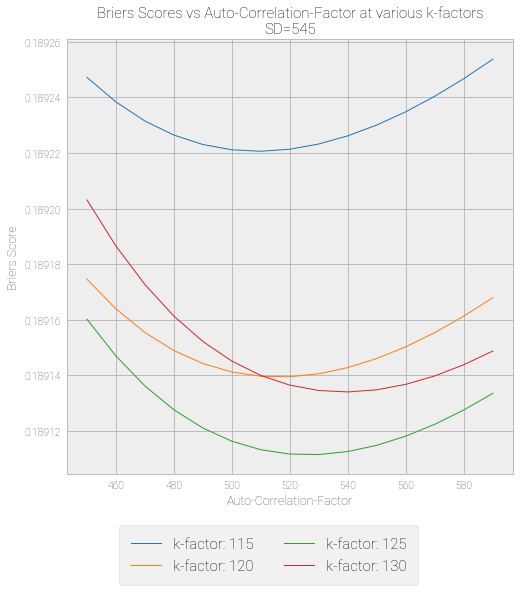

In [175]:
fig, ax = plt.subplots(figsize=(8,8))
for k in kfactor_range[3:7]:
    ax.plot(df_results_4[(df_results_4['kfactor'] == k) & (df_results_4['sd'] == 545)]['acf'].values, 
            df_results_4[(df_results_4['kfactor'] == k) & (df_results_4['sd'] == 545)]['briers_score_adv'].values,
            label=f'k-factor: {k}')
ax.legend(bbox_to_anchor=(0.1,-0.1), loc="upper left",ncol=2)
ax.set_title('Briers Scores vs Auto-Correlation-Factor at various k-factors\nSD=545')
ax.set_xlabel('Auto-Correlation-Factor')
ax.set_ylabel('Briers Score');

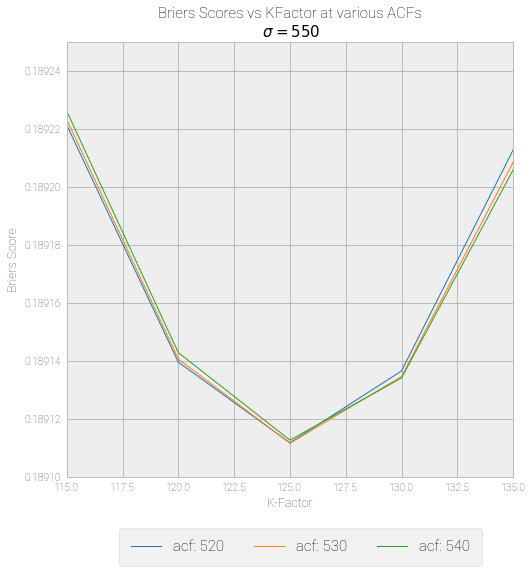

In [184]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[7:10]:
    ax.plot(df_results_4[(df_results_4['acf'] == a) & (df_results_4['sd'] == 545)]['kfactor'].values, 
            df_results_4[(df_results_4['acf'] == a) & (df_results_4['sd'] == 545)]['briers_score_adv'].values,
            label=f'acf: {a}')
ax.set_xlim(115,135)
ax.set_ylim(0.1891,0.18925)
ax.legend(bbox_to_anchor=(0.1,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs KFactor at various ACFs\n $\sigma=550$')
ax.set_xlabel('K-Factor')
ax.set_ylabel('Briers Score');

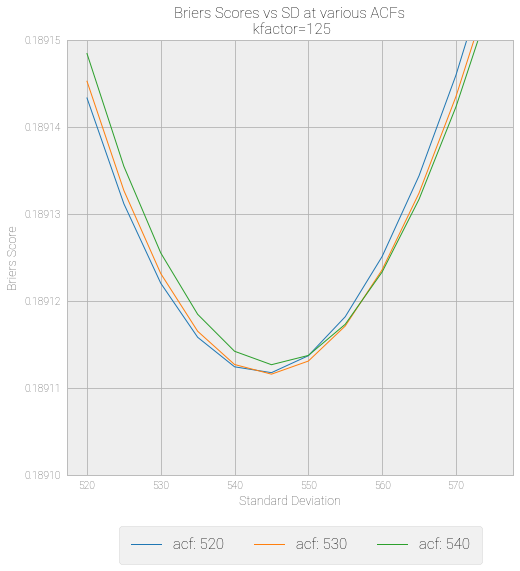

In [192]:
fig, ax = plt.subplots(figsize=(8,8))
for a in acf_range[7:10]:
    ax.plot(df_results_4[(df_results_4['acf'] == a) & (df_results_4['kfactor'] == 125)]['sd'].values, 
            df_results_4[(df_results_4['acf'] == a) & (df_results_4['kfactor'] == 125)]['briers_score_adv'].values,
            label=f'acf: {a}')
ax.set_ylim(0.18910, 0.18915)
ax.legend(bbox_to_anchor=(0.1,-0.1), loc="upper left",ncol=5)
ax.set_title('Briers Scores vs SD at various ACFs\n kfactor=125')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Briers Score');

#### Final Optimization Parameters
After a final round of tuning, the optimal parameters can be show to be:


| Brier's Score | $\sigma$ | kfactor | acf |
| --- | --- | --- | --- |
| 0.189112 | 545 | 125 | 530 |

<a id='feature_space'></a>
## Overview of Multi-Dimensional Feature Space

The objective of the above optimization process is to find the best combination of parameters to reduce the prediction error in the model. The combination of parameters is often referred to as the `feature space`. When you you have a single parameter, is is useful to plot this is 2D.

Dependant Variable - Briers Score / Model Evaluation Metric - y-axis
Independant Variable - Parameter being modified. e.g K-Factor - x-axis

This can also be done when you have two parameters, but then a 3D plot is required.

Some examples are shown below for Briers Score plotted against K-Factor and SD.

In [64]:
# sample input range uniformly at 0.1 increments
sd = np.arange(200, 600, 10)
kf = np.arange(100, 300, 10)
# create a mesh from the axis
x, y = np.meshgrid(sd, kf)

In [23]:
y.shape

(20, 40)

In [24]:
Z=[]

In [25]:
Z = []
for row_x, row_y in zip(x,y):
    vals = []
    for row_item_x, row_item_y in zip(row_x, row_y):
        vals.append(score_checker.check_prediction('MS',sd=row_item_x, kfactor=row_item_y))
    Z.append(vals)

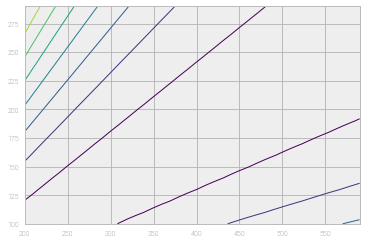

In [26]:
plt.contour(x, y, Z)

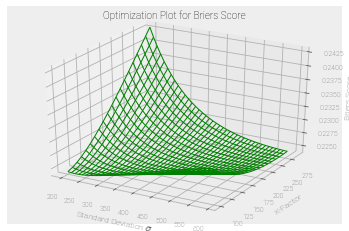

In [27]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(x, y, Z, color='green')
ax.set_xlabel('Standard Deviation $\sigma$')
ax.set_ylabel('K-Factor')
ax.set_zlabel('Briers Score')
ax.set_title('Optimization Plot for Briers Score')

plt.show()

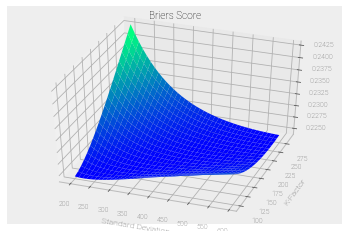

In [28]:
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('K-Factor')
ax.set_title('Briers Score')
ax.view_init(40, -70)

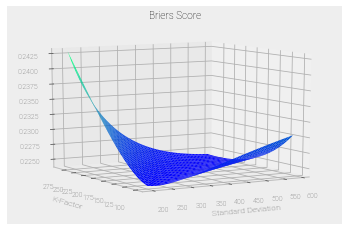

In [29]:
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('K-Factor')
ax.set_title('Briers Score')
ax.view_init(10, -120)

<a id='cold_start'></a>
## Cold Start Problem

Don't count predictions from algorithm before players rating has stabilised. This again is a trade off between wanting to get ratings and results to player, but also not wanting volatile or unreliable changes in ratings.

In the below example, it can be show that there is an increaes in accuracy of about 1% by requiring all players to have played at least 6-8 matches.

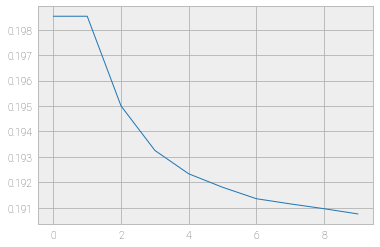

In [93]:
bs_list = []
for i in range(10):
    result_tmp = ResultsTable(df)
    result_tmp.cold_start_threshold = i
    bs_list.append(result_tmp.check_prediction(kfactor=125,sd=545,acf=530))

fig, ax = plt.subplots()
ax.plot(np.arange(10),bs_list)